In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\python\ML\pothole_detection_CNN\Datasetv2',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1284 files belonging to 3 classes.


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\DCL\AppData\Local\Temp\ipykernel_536\1970459322.py:2: SyntaxWarning: invalid escape sequence '\p'
  'E:\python\ML\pothole_detection_CNN\Datasetv2',


In [4]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [5]:
len(dataset)

41

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[2 0 0 0 1 1 0 0 1 2 2 2 2 2 1 2 2 2 0 1 0 0 1 0 1 2 0 0 0 0 0 1]


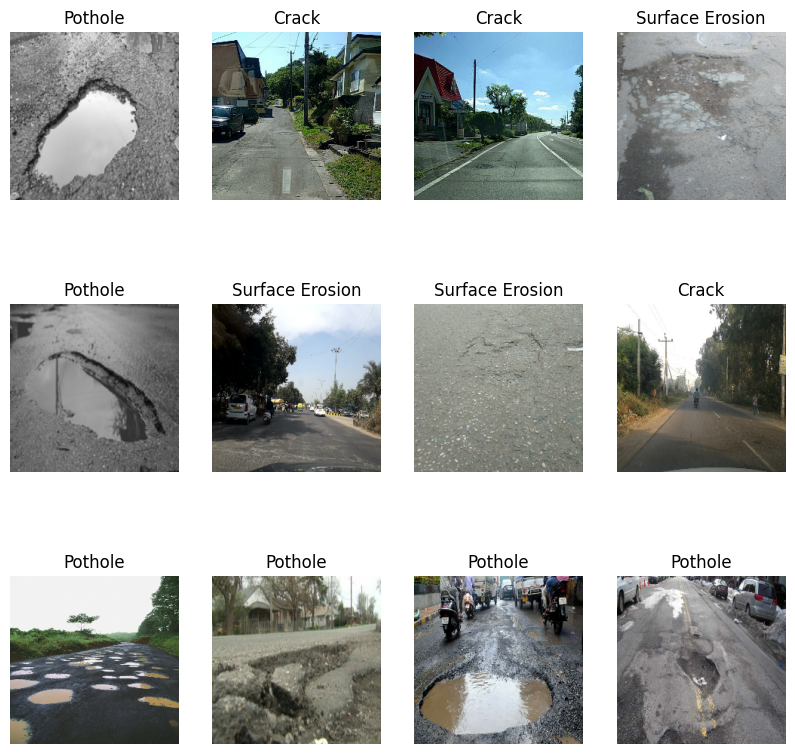

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
def partition_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds  = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    validation_size = int(val_split * ds_size)
    train_data = ds.take(train_size)
    validation_data = ds.skip(train_size).take(validation_size)
    test_data = ds.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data
train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 32
Validation data size: 4
Test data size: 5


In [9]:
len(train_data)
len(validation_data)
len(test_data)

5

In [10]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2)
])

In [13]:
# Model builders
def build_vgg19_model():
    base = tf.keras.applications.VGG19(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [14]:
model = build_vgg19_model()

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 233s 7s/step - accuracy: 0.4796 - loss: 1.0233 - val_accuracy: 0.6797 - val_loss: 0.7990
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 240s 8s/step - accuracy: 0.6793 - loss: 0.7722 - val_accuracy: 0.7188 - val_loss: 0.6781
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 241s 8s/step - accuracy: 0.7016 - loss: 0.7142 - val_accuracy: 0.7188 - val_loss: 0.6666
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 241s 8s/step - accuracy: 0.7280 - loss: 0.6518 - val_accuracy: 0.7344 - val_loss: 0.6023
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 239s 7s/step - accuracy: 0.7306 - loss: 0.6286 - val_accuracy: 0.7344 - val_loss: 0.6132
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 240s 8s/step - accuracy: 0.7332 - loss: 0.6135 - val_accuracy: 0.7266 - val_loss: 0.6112
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 240s 8s/step - accuracy: 0.7355 - loss: 0.6071 - val_accuracy: 0.7344 - val_loss: 0.6024
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 241s 8s/step - accuracy: 0.7792 - loss: 0.5576 - val_accuracy: 0.7812 - v

In [18]:
scores = model.evaluate(test_data)
scores

5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.8406 - loss: 0.3764


[0.3931735157966614, 0.8187500238418579]

In [19]:
model.save("Trained Modelv2/VGG19v1.o.h5")
model.save("Trained Modelv2/VGG19v1.o.keras")

In [20]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 32}

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [22]:
history.history['accuracy']

[0.5592369437217712,
 0.694779098033905,
 0.7108433842658997,
 0.7459839582443237,
 0.7389557957649231,
 0.7600401639938354,
 0.7580321431159973,
 0.7670682668685913,
 0.7761043906211853,
 0.7640562057495117,
 0.7771084308624268,
 0.7931727170944214,
 0.7891566157341003,
 0.8002008199691772,
 0.7931727170944214,
 0.805220901966095,
 0.814257025718689,
 0.8152610659599304,
 0.8343373537063599,
 0.7981927990913391,
 0.8253012299537659,
 0.8242971897125244,
 0.8242971897125244,
 0.8504015803337097,
 0.8423694968223572,
 0.8403614163398743,
 0.8353413939476013,
 0.8393574357032776,
 0.8313252925872803,
 0.8293172717094421,
 0.8433734774589539,
 0.8544176816940308,
 0.8544176816940308,
 0.8574297428131104,
 0.8604417443275452,
 0.8564257025718689,
 0.8564257025718689,
 0.8564257025718689,
 0.8744980096817017,
 0.8534136414527893,
 0.8634538054466248,
 0.8594377636909485,
 0.8594377636909485,
 0.8724899888038635,
 0.8694779276847839,
 0.8684738874435425,
 0.8785140514373779,
 0.8765060305595

In [23]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
F1 Score (macro): 0.8148260964478086
F1 Score (weighted): 0.8189012549688541

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.83      0.90      0.87        61
        Pothole       0.91      0.80      0.85        50
Surface Erosion       0.72      0.73      0.73        49

       accuracy                           0.82       160
      macro avg       0.82      0.81      0.81       160
   weighted avg       0.82      0.82      0.82       160



In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

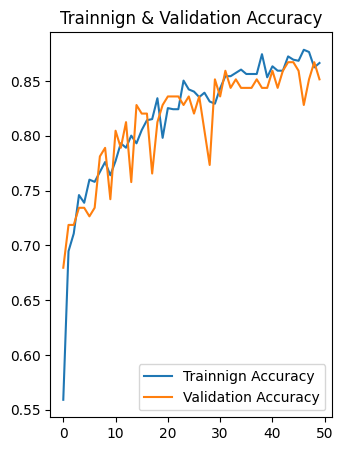

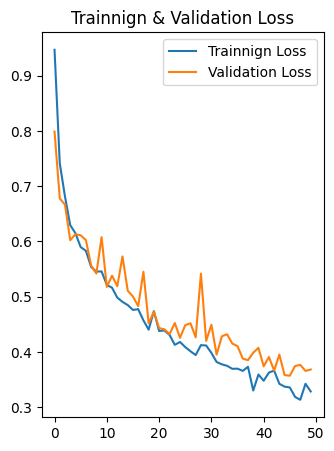

In [34]:

plt.figure(figsize = (8,5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,5))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [26]:
model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.7998 - loss: 0.4216


[0.3931735157966614, 0.8187500238418579]

First image to predict
First image actual label:  Crack
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted Label:  Crack


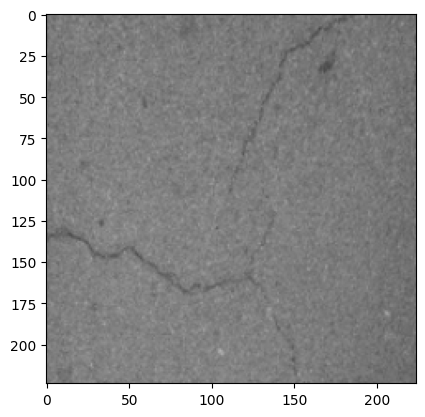

In [27]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->99.77999877929688 Light:-> Normal lighting
Confidence:->92.2699966430664 Light:-> Normal lighting
Confidence:->79.41999816894531 Light:-> Normal lighting
Confidence:->92.13999938964844 Light:-> Normal lighting
Confidence:->59.459999084472656 Light:-> Normal lighting
Confidence:->82.02999877929688 Light:-> Normal lighting
Confidence:->95.61000061035156 Light:-> Low light
Confidence:->99.98999786376953 Light:-> Normal lighting
Confidence:->75.97000122070312 Light:-> Normal lighting


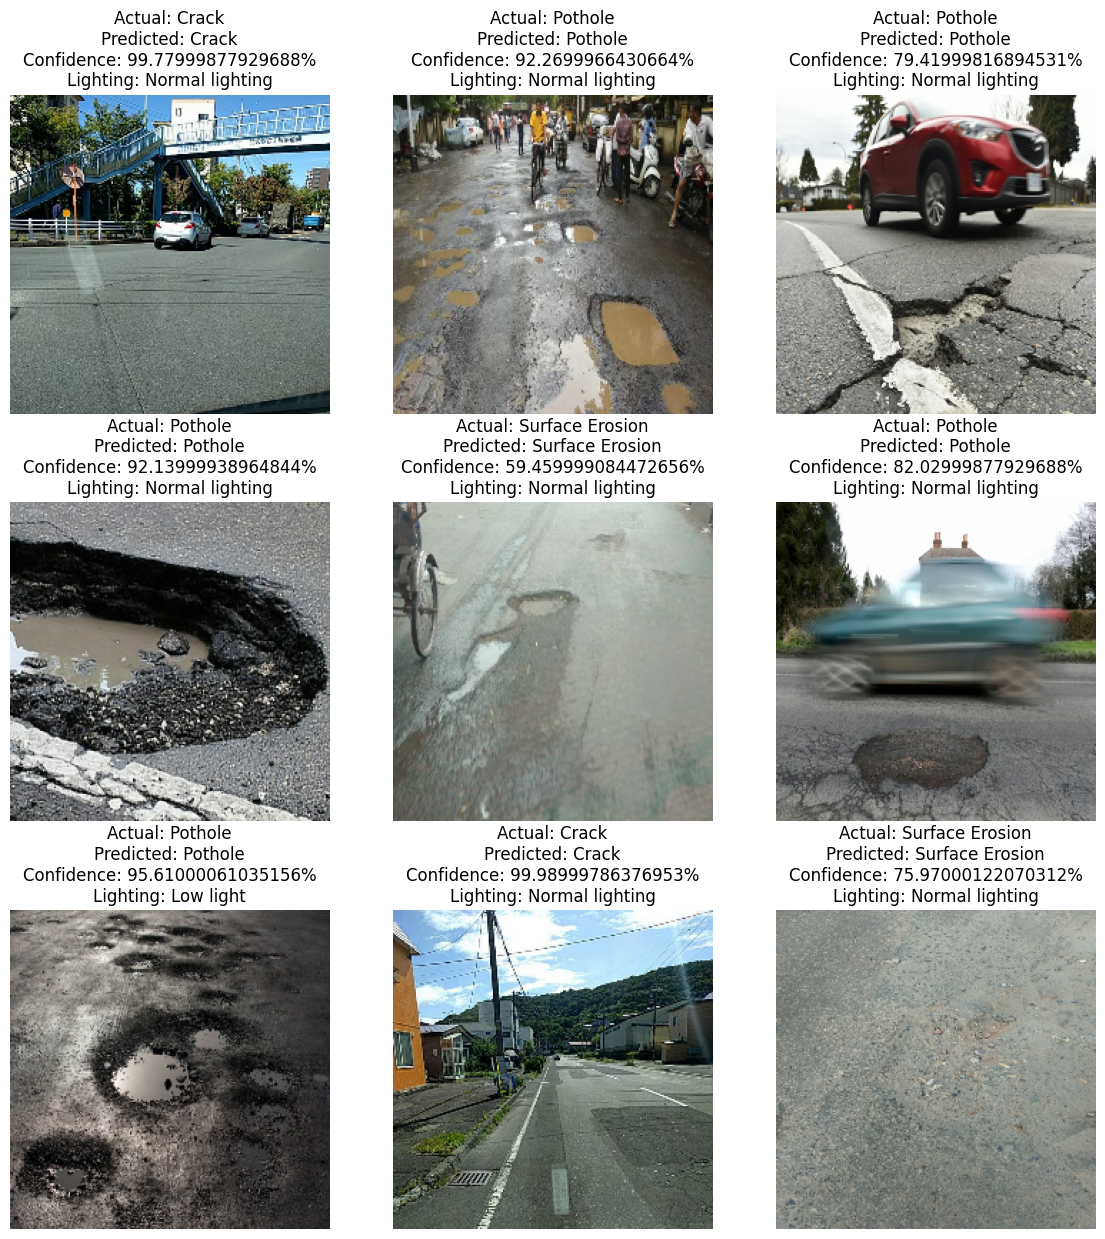

In [29]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [30]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Surface Erosion, Confidence: 75.97000122070312


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


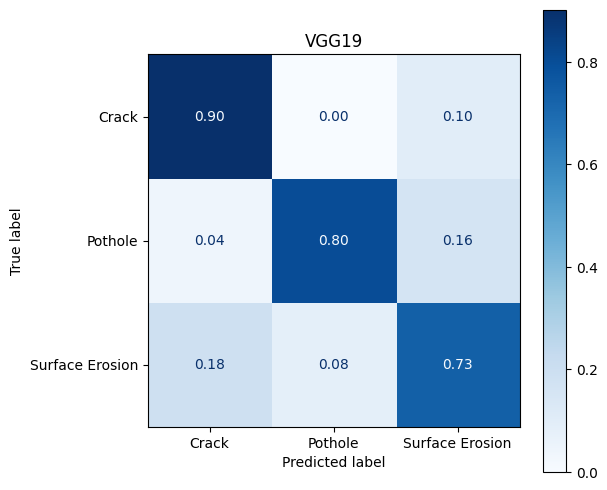

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []
for images, labels in test_data:
    predictions = model.predict(images)
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("VGG19")
plt.savefig("Confusion Matrx/VGG19.png", dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


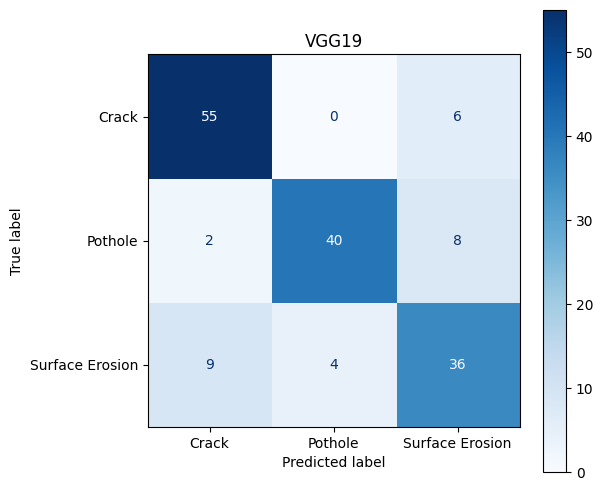

In [32]:
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format="d")  # "d" for integer values
plt.title("VGG19")
plt.savefig("Confusion Matrx/VGG19_counts.png", dpi=300, bbox_inches='tight')
plt.show()